# Introduction

The European Transaction Log (EUTL) is the backbone of the European Union Emissions Trading System (EUETS). It implements the transfer of emission allowances between parties active in the EUETS. The EUTL provides data on regulated installations, their emissions as well as transfers of allowances.  

Assuming that the database has been successfully populated with the EUTL data (see 1_create_database.ipynb), this notebook illustrates how to analyze compliance and transactions on the registry level.

Specifically, we consider the German registry with the identifier DE.

In [1]:
id_reg = "DE"

# Packages and options

In [2]:
from pyeutl.orm import DataAccessLayer       # data access layer to access the database
from pyeutl.orm import Country, Installation  # use country class to access registries
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

Database connection settings

In [3]:
connectionSettings = dict(
    user="eutlAdmin", 
    host="localhost", 
    db="eutl_orm", 
    passw="1234",
    port=5432
)

# Connect to database

Connect to database and get a session:

In [4]:
dal = DataAccessLayer(**connectionSettings)
session = dal.session

# Get registry

Given the registry id, use the session to get the registry:

In [5]:
registry = session.query(Country).get(id_reg)
print(registry.id + ": " + registry.name)

DE: Germany


# Installations

## Low-level access: Get installation objects

The country object has a property "installations_in_registry" which returns the query to get all installations registered in the country. The property "installations_in_country" returns all installations located in the country. 

In [6]:
inst = registry.installations_in_registry
inst

Given the query we can either fetch the results:

In [7]:
inst.first()          # get only first results
inst.all()            # get all results
inst.limit(5).all()   # get first 5 results 

[<Installation('DE_201569', '14557', <Country('DE', 'Germany')>)>,
 <Installation('DE_200437', '9243', <Country('DE', 'Germany')>)>,
 <Installation('DE_200440', '1778', <Country('DE', 'Germany')>)>,
 <Installation('DE_994', 'Heizkraftwerk Afferde', <Country('DE', 'Germany')>)>,
 <Installation('DE_1038', 'Fernheizwerk Neukölln', <Country('DE', 'Germany')>)>]

We could also further filter the results, e.g., getting all installations under activity 1 or 20 (combustion of fuels):

In [8]:
t_ = inst.filter(Installation.activity_id.in_([1, 20])).all()
print("Number of combustion installations: ", len(t_))

Number of combustion installations:  1511


## More easy: get_installations()

The low-level access is useful to directly get the installation objects which allows constructing different filters. For convenience, get_installations() implements a method that returns all installations in the registry as a Pandas dataframe.

In [9]:
inst = registry.get_installations()
inst.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2855 entries, 0 to 2854
Data columns (total 37 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   monitoringID         208 non-null    object        
 1   nace15_id            2288 non-null   object        
 2   registry_id          2855 non-null   object        
 3   postalCode           2854 non-null   object        
 4   addressSecondary     186 non-null    object        
 5   monitoringExpiry     0 non-null      object        
 6   nace20_id            2484 non-null   object        
 7   activity_id          2855 non-null   int64         
 8   city                 2854 non-null   object        
 9   monitoringFirstYear  208 non-null    object        
 10  nace_id              2692 non-null   object        
 11  eprtrID              2115 non-null   object        
 12  country_id           2854 non-null   object        
 13  permitDateExpiry     581 non-null

To get an overview about the number of activities we can use a simple groupby operation but need to to be aware that some installations do not have a Nace code assigned:

In [10]:
inst.groupby("nace", dropna=False)[["id"]].count().sort_values("id", ascending=False).head(5)

,id
nace,
Steam and air conditioning supply,598
Production of electricity,257
Air transport,208
NaN,163
Manufacture of paper and paperboard,159


Most installations provide either heat or electricity (or both). The large number of NaN results from aircraft operators that do not have a nace code assigned: 

In [11]:
inst[pd.isnull(inst.nace)].groupby(["activity", "activity_id"])[["id"]].count()\
        .sort_values("id", ascending=False).head(4)

,,id
activity,activity_id,
Combustion of fuels,20,71
Production of bulk chemicals,42,56
Combustion installations with a rated thermal input exceeding 20 MW,1,9
Production of paper or cardboard,36,6


The get_installation() method implements allows filtering installations based on installation attributes. For this, provide a dictionary with the installation attribute as key and a *list* as values. The dataframe returned only includes installations with attribute values as given in the respective list.

As an example, filter again for installations related to combustion activities:

In [12]:
filt = {"activity_id": [1, 20]}
t_ = registry.get_installations(filter=filt)
print("Number of combustion installations: ", len(t_))

Number of combustion installations:  1511


In [13]:
registry.get_installations(filter=filt).activity_id.unique()

array([20,  1], dtype=int64)

# Compliance

## Low-level: Using installation objects

Given a list of installation objects, we can analyze each installation in same manner as outline in the previous notebook. 

As an example, consider getting all compliance data for combustion activities in the selected registry:

In [14]:
comb = registry.installations_in_registry.filter(Installation.activity_id.in_([1, 20])).all()
print("Number of combustion installations: ", len(comb))

Number of combustion installations:  1511


Now follow the previous notebook and get the compliance data:

In [21]:
df_comb = pd.concat([c.get_compliance() for c in comb])
df_comb.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39286 entries, 0 to 25
Data columns (total 17 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   penalty                 0 non-null      object
 1   surrenderedCummulative  19732 non-null  object
 2   verifiedUpdated         39286 non-null  bool  
 3   verifiedCummulative     19429 non-null  object
 4   allocated10c            0 non-null      object
 5   allocatedNewEntrance    598 non-null    object
 6   compliance_id           18875 non-null  object
 7   reportedInSystem_id     39286 non-null  object
 8   installation_id         39286 non-null  object
 9   balance                 0 non-null      object
 10  surrendered             18577 non-null  object
 11  verified                19125 non-null  object
 12  allocatedTotal          39286 non-null  int64 
 13  allocatedFree           21362 non-null  object
 14  euetsPhase              39286 non-null  object
 15  year 

Accessing data in this way, has the advantage to be rather flexible in allowing to access that data for each installation. However, that comes at performance cost. Moreover, you either need to join installation information like names and activities or to further aggregate the data. 

Therefore, the country object provides further methods that already include these information and aggregations.

## High level: get_compliance()

get_compliance() returns a dataframe of compliance data related to the registry including limited installation details:

In [22]:
df_comp = registry.get_compliance()
df_comp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76423 entries, 0 to 76422
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   installation_id       76423 non-null  object 
 1   installation_name     76423 non-null  object 
 2   activity_id           76423 non-null  int64  
 3   activity              76423 non-null  object 
 4   nace_id               72203 non-null  object 
 5   nace                  72203 non-null  object 
 6   year                  76423 non-null  int64  
 7   surrendered           32005 non-null  float64
 8   verified              33408 non-null  float64
 9   allocatedTotal        76423 non-null  int64  
 10  allocatedFree         38225 non-null  float64
 11  allocated10c          14 non-null     float64
 12  allocatedNewEntrance  1256 non-null   float64
 13  nace_category         76423 non-null  object 
 14  activity_category     76423 non-null  object 
dtypes: float64(5), int6

Note that the installation data contain a special installation, that represent the Effort Sharing performance of the respective registry. This installation is always named after the two-digit country identifier and then esd. This approach was chosen to fit the ESD data into the general data model. It allows to easily access the ESD compliance of the registry. We next use the ESD identifier to separate EUETS compliance data from those under the ESD:

In [31]:
id_inst_esd = f"{id_reg}_esd"
df_comp_esd = df_comp[df_comp.installation_id == id_inst_esd].copy()
df_comp_euets = df_comp[df_comp.installation_id != id_inst_esd].copy()
df_comp_euets

,installation_id,installation_name,activity_id,activity,nace_id,nace,year,surrendered,verified,allocatedTotal,allocatedFree,allocated10c,allocatedNewEntrance,nace_category,activity_category
0,DE_200110,201,10,Aircraft operator activities,51,Air transport,2005,NaN,NaN,0,NaN,NaN,NaN,Air transport,Aircrafts
1,DE_200110,201,10,Aircraft operator activities,51,Air transport,2006,NaN,NaN,0,NaN,NaN,NaN,Air transport,Aircrafts
2,DE_200022,1776,10,Aircraft operator activities,51,Air transport,2005,NaN,NaN,0,NaN,NaN,NaN,Air transport,Aircrafts
3,DE_200060,21912,10,Aircraft operator activities,51,Air transport,2005,NaN,NaN,0,NaN,NaN,NaN,Air transport,Aircrafts
4,DE_200110,201,10,Aircraft operator activities,51,Air transport,2007,NaN,NaN,0,NaN,NaN,NaN,Air transport,Aircrafts
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76410,DE_1707,SWR HKW Merzdorf,20,Combustion of fuels,35.3,Steam and air conditioning supply,2026,NaN,NaN,0,NaN,NaN,NaN,Energy: Steam and air conditioning supply,Combustion
76411,DE_1707,SWR HKW Merzdorf,20,Combustion of fuels,35.3,Steam and air conditioning supply,2027,NaN,NaN,0,NaN,NaN,NaN,Energy: Steam and air conditioning supply,Combustion
76412,DE_1707,SWR HKW Merzdorf,20,Combustion of fuels,35.3,Steam and air conditioning supply,2028,NaN,NaN,0,NaN,NaN,NaN,Energy: Steam and air conditioning supply,Combustion
76413,DE_1707,SWR HKW Merzdorf,20,Combustion of fuels,35.3,Steam and air conditioning supply,2029,NaN,NaN,0,NaN,NaN,NaN,Energy: Steam and air conditioning supply,Combustion


The frame allows to easily aggregate compliance data by the respective dimension. As an example, plot verified emissions by NACE category over time:

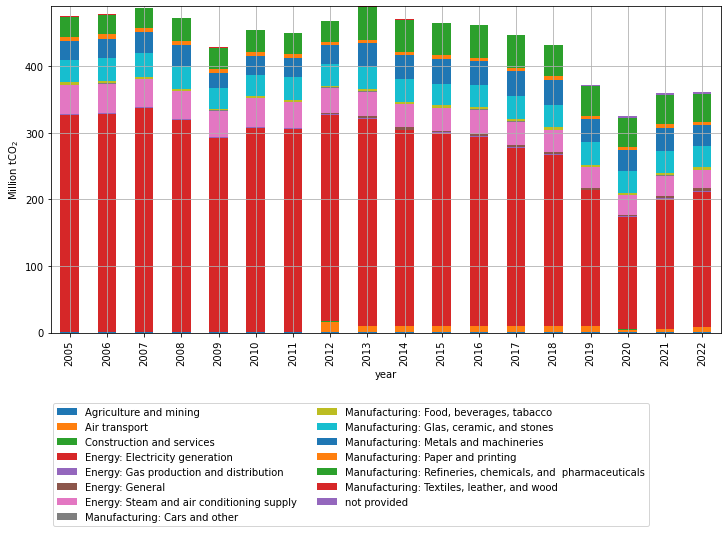

In [33]:
ax = ( df_comp_euets.query("year < 2023").groupby(["year", "nace_category"], as_index=False)
        .verified.sum()
        .pivot_table("verified", "year", "nace_category", dropna=False).div(1000000)
        .plot(kind="bar", stacked=True,  figsize=(12,6), ylabel=r"Million tCO$_2$", grid=True))
ax.legend(bbox_to_anchor=(0.9, -0.2), loc=0, ncol=2)

Likewise, by activity category:

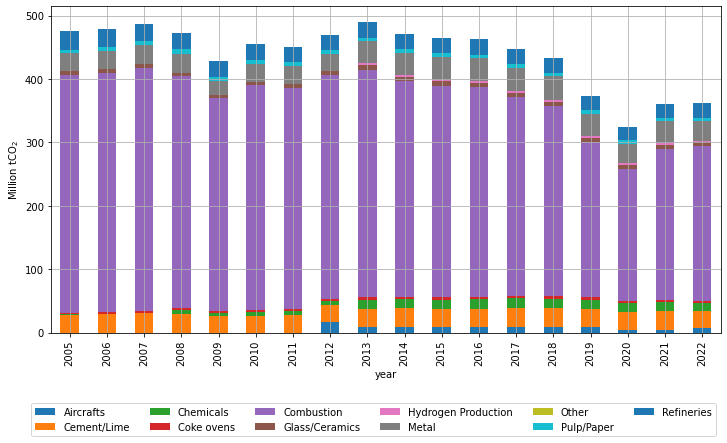

In [34]:
ax = df_comp_euets.query("year < 2023").groupby(["year", "activity_category"], as_index=False)\
        .verified.sum()\
        .pivot_table("verified", "year", "activity_category", dropna=False).div(1000000)\
        .plot(kind="bar", stacked=True,  figsize=(12,6), ylabel=r"Million tCO$_2$", grid=True)
ax.legend(bbox_to_anchor=(1, -0.2), loc=0, ncol=6)

For the effort sharing system we have only one installation and can directly plot emissions together with allocated and surrendered Assigned Amount Units (AAU)

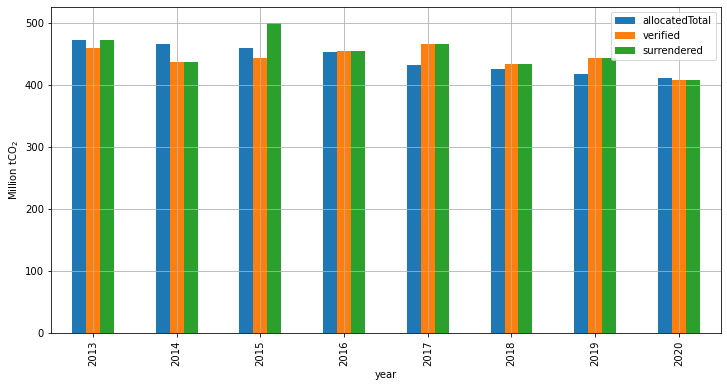

In [45]:
ax = ( (df_comp_esd.query("year < 2021")
        .set_index("year")
        [["allocatedTotal", "verified", "surrendered"]]/1000000)
        .plot(kind="bar", stacked=False,  figsize=(12,6), ylabel=r"Million tCO$_2$", grid=True)
     )

In [46]:
df_comp_esd.query("year < 2021").set_index("year")

,installation_id,installation_name,activity_id,activity,nace_id,nace,surrendered,verified,allocatedTotal,allocatedFree,allocated10c,allocatedNewEntrance,nace_category,activity_category
year,,,,,,,,,,,,,,
2013,DE_esd,Effort Sharing Installation: Germany,1000,EU Effort Sharing,None,None,472527651.0,460204908.0,472527651,NaN,NaN,NaN,not provided,not provided
2014,DE_esd,Effort Sharing Installation: Germany,1000,EU Effort Sharing,None,None,436790185.0,436790185.0,465830461,NaN,NaN,NaN,not provided,not provided
2015,DE_esd,Effort Sharing Installation: Germany,1000,EU Effort Sharing,None,None,500496290.0,444080615.0,459133271,NaN,NaN,NaN,not provided,not provided
2016,DE_esd,Effort Sharing Installation: Germany,1000,EU Effort Sharing,None,None,454157411.0,454157411.0,452436081,NaN,NaN,NaN,not provided,not provided
2017,DE_esd,Effort Sharing Installation: Germany,1000,EU Effort Sharing,None,None,466857281.0,466857281.0,432348857,NaN,NaN,NaN,not provided,not provided
2018,DE_esd,Effort Sharing Installation: Germany,1000,EU Effort Sharing,None,None,434047773.0,434047773.0,425202158,NaN,NaN,NaN,not provided,not provided
2019,DE_esd,Effort Sharing Installation: Germany,1000,EU Effort Sharing,None,None,444262722.0,444262722.0,418055459,NaN,NaN,NaN,not provided,not provided
2020,DE_esd,Effort Sharing Installation: Germany,1000,EU Effort Sharing,None,None,407410808.0,407410808.0,410908761,NaN,NaN,NaN,not provided,not provided
